Found 7 files to plot.
$Baseline$ 0.07414716730515163 0.0051497244
$\Phi(r)=\cosh(r)$ 0.006163294427096844 3.1506515e-05
$vRBA: \Phi(r)=e^{r}$ 0.007067288737744093 4.3543194e-05
$\Phi(r)=\log(1+r)$ 0.006429263080159823 3.3096156e-05
$\Phi(r)=r^{p}$ 0.004997510618219773 1.8407265e-05
$RBA: \Phi(r)=r^{2}$ 0.005280945760508378 2.074303e-05
$\Phi(r)=e^{r^2}$ 0.00540621733913819 2.3625344e-05


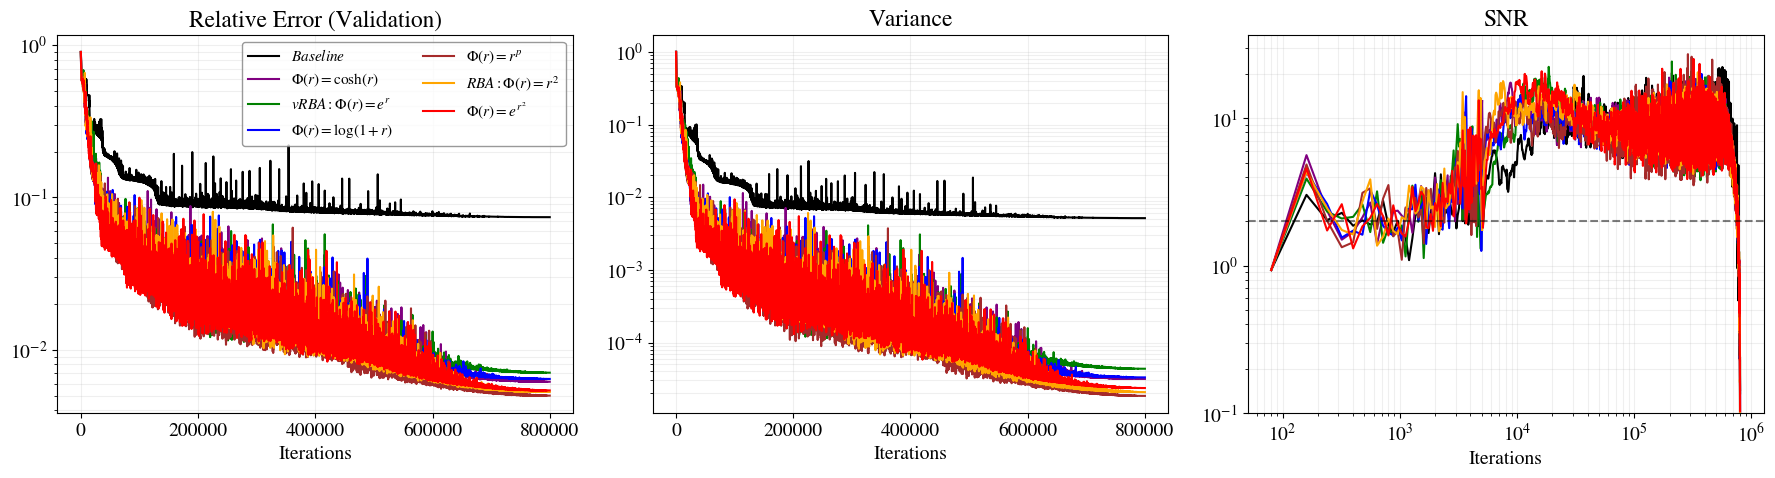

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.io
import os
import glob

# --- Global style settings ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- Setup Paths ---
results_dir = 'results'
save_path = "all_results_mat"
os.makedirs(save_path, exist_ok=True)

# Find all metric files
file_list = glob.glob(os.path.join(results_dir, "metrics_*.npz"))
print(f"Found {len(file_list)} files to plot.")

# --- Constants from your Original Code ---
batch_size_scaler = 80
smoothing_start_iter = 5000
moving_average_window = 10

# --- Mapping Potentials to LaTeX Labels and Colors ---
potential_map = {
    # Fixed Colors
    'Vanilla': {'label': r'$Baseline$', 'color': 'k'},  # Green
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},  # Green
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'}, # Orange
    
    # Sequential Colors
    'logarithmic': {'label': r'$\Phi(r)=\log(1+r)$',   'color': 'blue'},   # Blue
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'Brown'},  # Brown
    'sublinear':   {'label': r'$\Phi(r)=\sqrt{r}$',    'color': 'Magenta'},# Magenta
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},   # Cyan
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'Purple'}, # Purple
}

def get_plot_style(filename):
    """Extracts potential name from filename and returns label/color."""
    name = os.path.basename(filename).replace("metrics_", "").replace(".npz", "")
    parts = name.split('_')
    pot_key = parts[0] 
    
    # Logic to handle naming variations
    if 'vrba' in name.lower() or pot_key == 'exponential':
        return potential_map['exponential']
    elif 'rba' in name.lower() and 'vrba' not in name.lower():
        return potential_map['quadratic']
    elif 'uniform' in name.lower() or 'baseline' in name.lower():
        return potential_map['Baseline']
        
    if pot_key in potential_map:
        return potential_map[pot_key]
    else:
        return {'label': rf'$\Phi(r)={pot_key}$', 'color': 'black'}

# --- Plotting Function ---
def plot_results(files):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # Increased width slightly for visibility
    
    # Sort files for consistency
    files.sort()

    for filepath in files:
        # 1. Load Data
        try:
            data = np.load(filepath)
            epochs = data['epochs']
            val_loss = data['val_loss']
            var_residual = data['var_residual']
            snr = data['snr']
        except Exception as e:
            print(f"Skipping {filepath}: {e}")
            continue
        
        # Calculate Scaled Iterations
        iterations = epochs * batch_size_scaler
        
        # Determine Style
        style = get_plot_style(filepath)
        label = style['label']
        color = style['color']
        
        # 2. Save to .mat
        base_name = os.path.basename(filepath).replace(".npz", ".mat")
        mat_save_path = os.path.join(save_path, base_name)
        scipy.io.savemat(mat_save_path, {
            'all_its': iterations.reshape(1, -1),
            'all_errors': val_loss.reshape(1, -1),
            'all_Var_q': var_residual.reshape(1, -1),
            'all_SNR_psi': snr.reshape(1, -1)
        })

        # 3. Plotting
        
        # Plot 1: Relative Error
        axes[0].plot(iterations, val_loss, label=label, color=color, linewidth=1.5)
        
        # Plot 2: Standard Deviation (Sqrt of Variance)
        std_dev = var_residual
        axes[1].plot(iterations, std_dev, label=label, color=color, linewidth=1.5)
        
        # Plot 3: SNR (Split Smoothing Logic)
        smoothing_start_index = smoothing_start_iter // batch_size_scaler
        
        # Part A: Plot raw data up to smoothing index
        axes[2].plot(iterations[:smoothing_start_index + 1],
                     snr[:smoothing_start_index + 1],
                     label=label if smoothing_start_index == len(snr) else "", 
                     color=color, linewidth=1.5)
        
        # Part B: Smooth and plot the rest
        if len(snr) > smoothing_start_index:
            data_to_smooth = snr[smoothing_start_index:]
            x_for_smoothing = iterations[smoothing_start_index:]
            
            # Apply convolution only to the tail
            smoothed_data = np.convolve(data_to_smooth, np.ones(moving_average_window) / moving_average_window, mode='same')
            
            # Stitch the start to ensure continuity
            smoothed_data[0] = snr[smoothing_start_index]
            
            # Plot the smoothed tail
            axes[2].plot(x_for_smoothing, smoothed_data, label=label, color=color, linewidth=1.5)
        print(label,val_loss[-1],var_residual[-1])
    # --- Formatting ---
    titles = ["Relative Error (Validation)", r"Variance", "SNR"]
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i])
        ax.set_xlabel("Iterations")
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="-", alpha=0.2)
        
        if i == 2: # SNR specific
             ax.set_ylim(bottom=0.1)
             ax.set_xscale('log')
             ax.axhline(y=2, color='k', linestyle='--', alpha=0.5)

    # --- LEGEND PLACEMENT (Inside Plot 1) ---
    axes[0].legend(fontsize=11, loc='best',ncols=2, framealpha=0.8, edgecolor='gray')

    plt.tight_layout()
    plt.savefig("Comparison_Potentials.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- Run ---
plot_results(file_list)

Found 7 files to plot.
$Baseline$ 0.07414716730515163 0.0051497244
$\Phi(r)=\cosh(r)$ 0.0062017240561544895 3.0219107e-05
$vRBA: \Phi(r)=e^{r}$ 0.005163268186151981 1.9367952e-05
$\Phi(r)=\log(1+r)$ 0.005733732289324204 2.6396323e-05
$\Phi(r)=r^{p}$ 0.009094404677549997 6.336129e-05
$RBA: \Phi(r)=r^{2}$ 0.005718408773342769 2.4293402e-05
$\Phi(r)=e^{r^2}$ 0.010198964116473993 8.596812e-05


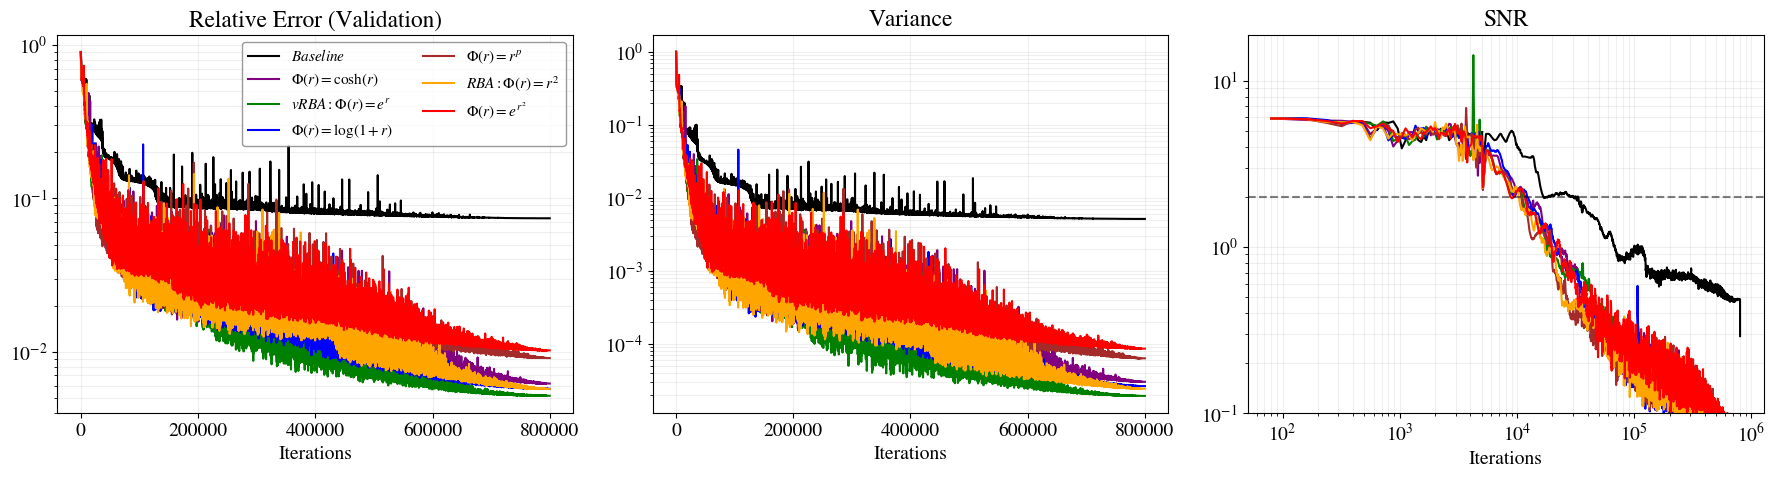

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.io
import os
import glob

# --- Global style settings ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- Setup Paths ---
results_dir = 'results'
save_path = "all_results_mat"
os.makedirs(save_path, exist_ok=True)

# Find all metric files
file_list = glob.glob(os.path.join(results_dir, "metrics_*.npz"))
print(f"Found {len(file_list)} files to plot.")

# --- Constants from your Original Code ---
batch_size_scaler = 80
smoothing_start_iter = 5000
moving_average_window = 10

# --- Mapping Potentials to LaTeX Labels and Colors ---
potential_map = {
    # Fixed Colors
    'Vanilla': {'label': r'$Baseline$', 'color': 'k'},  # Green
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},  # Green
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'}, # Orange
    
    # Sequential Colors
    'logarithmic': {'label': r'$\Phi(r)=\log(1+r)$',   'color': 'blue'},   # Blue
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'Brown'},  # Brown
    'sublinear':   {'label': r'$\Phi(r)=\sqrt{r}$',    'color': 'Magenta'},# Magenta
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},   # Cyan
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'Purple'}, # Purple
}

def get_plot_style(filename):
    """Extracts potential name from filename and returns label/color."""
    name = os.path.basename(filename).replace("metrics_", "").replace(".npz", "")
    parts = name.split('_')
    pot_key = parts[0] 
    
    # Logic to handle naming variations
    if 'vrba' in name.lower() or pot_key == 'exponential':
        return potential_map['exponential']
    elif 'rba' in name.lower() and 'vrba' not in name.lower():
        return potential_map['quadratic']
    elif 'uniform' in name.lower() or 'baseline' in name.lower():
        return potential_map['Baseline']
        
    if pot_key in potential_map:
        return potential_map[pot_key]
    else:
        return {'label': rf'$\Phi(r)={pot_key}$', 'color': 'black'}

# --- Plotting Function ---
def plot_results(files):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # Increased width slightly for visibility
    
    # Sort files for consistency
    files.sort()

    for filepath in files:
        # 1. Load Data
        try:
            data = np.load(filepath)
            epochs = data['epochs']
            val_loss = data['val_loss']
            L_infty = data['val_loss']
            var_residual = data['var_residual']
            snr = data['L_infty_residual']
        except Exception as e:
            print(f"Skipping {filepath}: {e}")
            continue
        
        # Calculate Scaled Iterations
        iterations = epochs * batch_size_scaler
        
        # Determine Style
        style = get_plot_style(filepath)
        label = style['label']
        color = style['color']
        
        # 2. Save to .mat
        base_name = os.path.basename(filepath).replace(".npz", ".mat")
        mat_save_path = os.path.join(save_path, base_name)
        scipy.io.savemat(mat_save_path, {
            'all_its': iterations.reshape(1, -1),
            'all_errors': val_loss.reshape(1, -1),
            'all_Var_q': var_residual.reshape(1, -1),
            'all_SNR_psi': snr.reshape(1, -1)
        })

        # 3. Plotting
        
        # Plot 1: Relative Error
        axes[0].plot(iterations, val_loss, label=label, color=color, linewidth=1.5)
        
        # Plot 2: Standard Deviation (Sqrt of Variance)
        std_dev = var_residual
        axes[1].plot(iterations, std_dev, label=label, color=color, linewidth=1.5)
        
        # Plot 3: SNR (Split Smoothing Logic)
        smoothing_start_index = smoothing_start_iter // batch_size_scaler
        
        # Part A: Plot raw data up to smoothing index
        axes[2].plot(iterations[:smoothing_start_index + 1],
                     snr[:smoothing_start_index + 1],
                     label=label if smoothing_start_index == len(snr) else "", 
                     color=color, linewidth=1.5)
        
        # Part B: Smooth and plot the rest
        if len(snr) > smoothing_start_index:
            data_to_smooth = snr[smoothing_start_index:]
            x_for_smoothing = iterations[smoothing_start_index:]
            
            # Apply convolution only to the tail
            smoothed_data = np.convolve(data_to_smooth, np.ones(moving_average_window) / moving_average_window, mode='same')
            
            # Stitch the start to ensure continuity
            smoothed_data[0] = snr[smoothing_start_index]
            
            # Plot the smoothed tail
            axes[2].plot(x_for_smoothing, smoothed_data, label=label, color=color, linewidth=1.5)
        print(label,val_loss[-1],var_residual[-1])
    # --- Formatting ---
    titles = ["Relative Error (Validation)", r"Variance", "SNR"]
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i])
        ax.set_xlabel("Iterations")
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="-", alpha=0.2)
        
        if i == 2: # SNR specific
             ax.set_ylim(bottom=0.1)
             ax.set_xscale('log')
             ax.axhline(y=2, color='k', linestyle='--', alpha=0.5)

    # --- LEGEND PLACEMENT (Inside Plot 1) ---
    axes[0].legend(fontsize=11, loc='best',ncols=2, framealpha=0.8, edgecolor='gray')

    plt.tight_layout()
    plt.savefig("Comparison_Potentials.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- Run ---
plot_results(file_list)